# Projet d'attaques adversariales


##Projet 3 : Nicolas Fabiano, Minh Binh & Alexis Amzallag

Ce projet à pour but d'aborder le sujet des attaques adversiales. C'est-à-dire de réussir, par une modification la plus imperceptible possible, à tromper un réseau de neurone entraîné pour un problème de classification.

Trois approches seront ici abordées :

*   la Fast Gradient Sign Method
*   la Projected Gradient Descent
*   les attaques Black Box





# **I. Fast Gradient Sign Method**


Le principe de la FGSM repose sur l'idée de trouver une perturbation à infliger à l'image source telle que chaque pixel perturbé ne soit, individuellement, pas "trop" différent du pixel de l'image source. C'est-à-dire de trouver une perturbation dont la valeur de norme l-infini ne soit pas "trop" élevée.


Il s'agira donc de trouver, pour chaque pixel, de trouver "dans quel sens" le modifier par liais du gradient (ou plutôt de son signe), et de lui affecter dans se sens le changement maximal que l'on aura autorisé. 

##Imports

In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dense
from keras.optimizers import RMSprop
from keras.losses import sparse_categorical_crossentropy
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random


##Functions##

In [0]:
''' Cette foncion retourne les signes du gradient pour un réseau et une image donnés'''
def get_sign(image, label, model):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    sign_gradient = tf.sign(gradient)
    
    return sign_gradient

In [0]:
''' Cette fonction donne, pour une image et un modèle donnés, la perturbation à efféctuée pour un epsilon valant 1'''
def get_pertur(image, image_label, model) :
  pertur = K.eval(get_sign(image.reshape((1, 32, 32, 3)), image_label, model))
  return pertur


In [0]:
''' Cette fonction permet de réduire une pertubation aux seules contours d'une image'''
def get_pertur2(perturbation, min, max) :
  pertur = perturbation
  for ab in range(32) :
    for j in range(32) :
      if (min<ab<max and min<j<max):
        pertur[0][ab][j] = [0,0,0]
  return pertur
    

In [0]:
''' Cette fonction permet de créer une perturbation pour laquel le sens de modification de chaque pixel est aléatoire'''
def get_pertur3() :
  pertur = np.zeros((1, 32, 32, 3))
  for ab in range(32) :
    for j in range(32) :
      pertur[0][ab][j] = [1 - 2 * random.randint(0,1),1 - 2 * random.randint(0,1), 1-2 * random.randint(0,1)]
  return pertur

In [0]:
'''Cette fonction retourne, pour une liste d'image données, la liste des perturbations obtenues par FGSM'''
def get_perturbations1(dataX, dataY, model) :
  resultat = []
  for i in range(len(dataX)) :
    if (i%50 == 0):
      print(i)
    resultat.append(get_pertur(dataX[i], dataY[i], model))
  return resultat


In [0]:
def get_perturbations2(pertur, min, max) :
  resultat = []
  for i in range(len(pertur)) :
    resultat.append(get_pertur2(pertur[i], min, max))
  return resultat

In [0]:
def get_perturbations3(dataX) :
  resultat = []
  for i in range(len(dataX)) :
    resultat.append(get_pertur3())
  return resultat

In [0]:
''' Cette fonction renvoie, à partir d'une liste d'image et de perturbations ainsi que du seuil autorisé pour la perturbation, la liste des images modifiées'''
def get_attacks(originalX, perturbations, epsilon) :
  res = []
  
  for i in range(len(originalX)) :
    res.append(originalX[i].reshape(1,32,32,3) + epsilon * perturbations[i])
  return res

In [0]:
''' Retourne différentes informations sur l'accuracy et la confiance du modèle sur un groupe d'images attaquées '''

def get_evaluation(originalX, originalY, perturbatedX) :
  nbCorrectPer = 0
  sumConfTTPer = 0
  sumConfTFPer = 0
  sumConfFFPer = 0
  for i in range(len(originalX)) :
    predictionOri = model.predict(originalX[i].reshape(1,32,32,3))
    predictionPer = model.predict(perturbatedX[i].reshape(1,32,32,3))
    if (predictionPer.argmax() == int(originalY[i])) :
      nbCorrectPer += 1
      sumConfTTPer += predictionPer.max()
    if (predictionPer.argmax() != int(originalY[i])) :
      sumConfFFPer += predictionPer.max()
      sumConfTFPer += predictionPer[0][int(originalY[i])]
    
  if(nbCorrectPer != 0):
    sumConfTTPer = sumConfTTPer/nbCorrectPer

  if(nbCorrectPer !=len(originalX)):
    sumConfTFPer = sumConfTFPer/(len(originalX)- nbCorrectPer)
    sumConfFFPer = sumConfFFPer/(len(originalX)- nbCorrectPer)
  nbCorrectPer = nbCorrectPer/len(originalX)

  return nbCorrectPer, sumConfTTPer, sumConfTFPer, sumConfFFPer





##Entrainement du réseau à attaquer

On crée puis entraîne un réseau que l'on va par la suite attaquer

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
inputs = Input(shape=(32,32,3), name='img')
x = Conv2D(32, 5, activation='relu', padding='same')(inputs)
x = MaxPooling2D(2)(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = AveragePooling2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

In [30]:
model = Model(inputs=inputs, outputs=outputs, name='classif')
model.summary()

model.compile(loss='sparse_categorical_crossentropy',optimizer=RMSprop(lr=0.0001, decay=1e-6),metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128,epochs=400,validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Model: "classif"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 32)          0   

##Principe

Le principe est le suivant : on choisit un epsilon traduisant d'a quel point on s'autorise a modifier l'image, et on perturbe chaque pixel en conséquence. Plus epsilon sera grand, plus grande sera la perturbation et plus facile il sera de tromper le réseau, mais plus facile il sera aussi distinguer que l'image a été modifiée.

In [31]:
examples = [0, 0.005, 0.01, 0.031, 0.1]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = [get_attacks(x_train[62:64], perturbations1_train[62:64], cdef) for cdef in examples]

for i in range(len(examples)):
  predicti1 = model.predict(imgsadv[i][0].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(imgsadv[i][0].reshape(32,32,3))
  plt.xlabel('Epsilon = {}'.format(examples[i]))
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  
  predicti1 = model.predict(imgsadv[i][1].reshape(1,32,32,3))

  plt.subplot(2,len(examples), i+5+1)
  plt.imshow(imgsadv[i][1].reshape(32,32,3))
  plt.xlabel('Epsilon = {}'.format(examples[i]))
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
plt.show()

NameError: ignored

<Figure size 1600x640 with 0 Axes>

##**1) Attaque FGSM classique**

On implémente les attaques FGSM sur cifar10.

In [0]:
#On recupère les perturbations pour les 500 premières images de la base de train
x_usedtr1 = x_train[:500]
y_usedtr1 = y_train[:500]
perturbations1_train = get_perturbations1(x_train[:500], y_train[:500])
perturbations2_train = get_perturbations2(np.copy(perturbations1_train), 3, 28)
perturbations3_train = get_perturbations3(x_train[:500])

In [0]:
#On recupère les perturbations pour les 500 premières images de la base de test
x_usedte1 = x_test[:500]
y_usedte1 = y_test[:500]
perturbations1_test = get_perturbations1(x_test[:500], y_test[:500])
perturbations2_test = get_perturbations2(np.copy(perturbations1_test), 3, 28)
perturbations3_test = get_perturbations3(x_test[:500])

In [0]:
epsilons = [0, 0.001, 0.003, 0.007, 0.01, 0.02, 0.031, 0.045, 0.07]
resAccTr = []
resConfTTTr = []
resConfTFTr = []
resConfFFTr = []
resAccTe = []
resConfTTTe = []
resConfTFTe = []
resConfFFTe = []
for i in epsilons :
  print(i)
  a, b, c, d = get_evaluation(x_usedtr1, y_usedtr1, get_attacks(x_usedtr1, perturbations1_train, i))
  e, f, g, h = get_evaluation(x_usedte1, y_usedte1, get_attacks(x_usedte1, perturbations1_test, i))
  resAccTr.append(a)
  resConfTTTr.append(b)
  resConfTFTr.append(c)
  resConfFFTr.append(d)
  resAccTe.append(e)
  resConfTTTe.append(f)
  resConfTFTe.append(g)
  resConfFFTe.append(h)


0
True
372
0.5487406322499737 0.18108267415163937 0.7756679922502528
True
336
0.5531501148532076 0.16638999456380388 0.7649651910400107
0.001
True
346
0.5669111405293663 0.17244796283590735 0.7549073111287431
True
306
0.5635073970734459 0.15707003876490228 0.7517343243352728
0.003
True
281
0.5852639328807456 0.16386828053762315 0.7291272055105806
True
248
0.593211757048728 0.14124312176573722 0.7244978322977981
0.007
True
156
0.6256319022802419 0.13101858000400593 0.7353122383356094
True
142
0.6379899856265031 0.10903680140398533 0.7224893716859145
0.01
True
106
0.6702086257223551 0.09744167618306525 0.7229796234729156
True
93
0.6722149449865121 0.08797961270799155 0.7099945256786961
0.02
True
32
0.7535257464290684 0.039087376740604265 0.6967099504545331
True
22
0.7406461844883204 0.03937876175103855 0.6784086986021562
0.031
True
6
0.7843233329443796 0.020033056287063564 0.616248200337092
True
4
0.7766556160584572 0.01693647757046818 0.861845463514328
0.045
True
1
0.7988138933458883 0.

On présente ici les conséquences de l'évolution d'epsilon sur l'accuracy du réseau (pour des exemples d'entrainement comme pour des exemples de test) et sur les niveaux de confiance.

On distinguera 3 moyennes de confiance différentes :

*   TT : la moyenne des confiances que le réseau a dans la vrai classe d'une image lorsqu'il prédit la bonne classe
*   TF : la moyenne des confiances que le réseau a dans la vrai classe d'une image lorsqu'il ne prédit pas la bonne classe
*   FF : la moyenne des confiances que le réseau a dans ses prédictions lorsque ses prédictions sont erronnées.



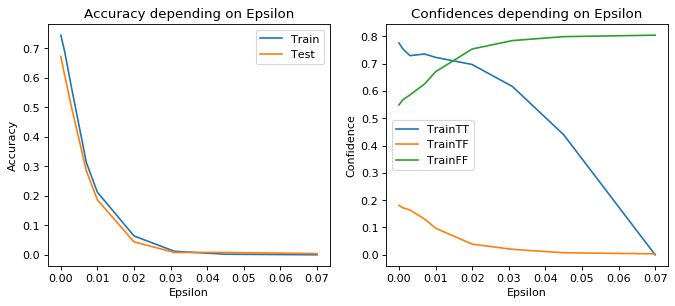

In [0]:
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(121)
plt.plot(epsilons, resAccTr)
plt.plot(epsilons, resAccTe)
plt.title('Accuracy depending on Epsilon')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.subplot(122)
plt.plot(epsilons, resConfTTTr)
plt.plot(epsilons, resConfTFTr)
plt.plot(epsilons, resConfFFTr)
plt.title('Confidences depending on Epsilon')
plt.ylabel('Confidence')
plt.xlabel('Epsilon')
plt.legend(['TrainTT', 'TrainTF', 'TrainFF'], loc='center left')
plt.show()

Les résultats sont probants, pour un epsilon à 0.031, la perturbation est presque imperceptible et le réseau ne fonctionne plus du tout avec un accuracy à 2-3%. On présente ci-dessous quelques exemples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[[1.57090707e-03 1.42447971e-04 2.01100130e-02 4.11387384e-02
  9.57064852e-02 6.12757623e-01 8.39446264e-04 2.27312967e-01
  1.08436005e-04 3.12911026e-04]] 5
[[8.9199990e-01 8.1820443e-04 1.6230989e-02 6.0697589e-03 1.4000225e-02
  8.7159096e-05 2.2979355e-03 4.0217911e-04 5.6495972e-02 1.1597669e-02]] 0
[[3.2253981e-01 2.3899914e-03 1.5468870e-03 1.6803530e-04 1.0891880e-03
  2.5368433e-06 1.0546263e-04 6.7314891e-06 6.7105722e-01 1.0941484e-03]] 8
[[1.4820585e-03 3.6419975e-04 3.8617514e-02 1.3288851e-02 5.1931566e-01
  3.1155652e-01 1.2068021e-02 1.0257169e-01 7.0842907e-05 6.6460535e-04]] 4


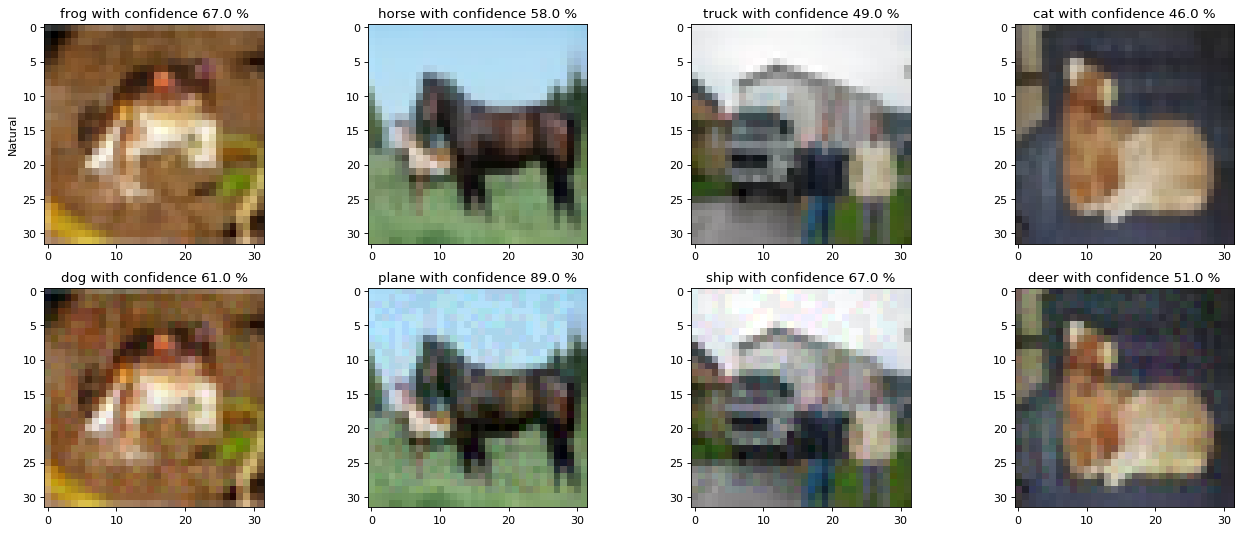

In [0]:
examples = [0,12,16,17]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = get_attacks([x_train[abcd] for abcd in examples], [perturbations1_train[bcde] for bcde in examples], 0.031)
print (imgsadv[0].shape)

for i in range(len(examples)):
  predicti1 = model.predict(x_train[examples[i]].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(x_train[examples[i]])
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  if(i ==0):
    plt.ylabel('Natural')
  
  predicti2 = model.predict(imgsadv[i].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+4+1)
  plt.imshow(imgsadv[i].reshape(32,32,3))
  plt.title("{} with confidence {} %".format(classes[predicti2.argmax()], predicti2.max()//0.01))
  if(i ==4):
    plt.ylabel('Adversarial')
plt.show()


##**2.Attaque FGSM partielle**

Ici on va restreindre les attaques FGSM au contour de l'image de manière à ne pas perturber la partie de l'image dans laquelle se situe le sujet de l'image. 

Le but de cette manoeuvre serait d'observer dans quelle mesure l'on pourrait attaquer une image sans toucher a ses parties les plus importantes. 

A noter que pour la plupart des classes, les images correspondantes représentent leur sujet dans des décors variés, ainsi on trouve des grenouilles dans de l'herbe de l'eau, de la boue, une main ou encore sur un trottoir.


In [0]:
epsilons = [0, 0.001, 0.003, 0.007, 0.01, 0.02, 0.031, 0.05, 0.075, 0.1]
resAccTr = []
resConfTTTr = []
resConfTFTr = []
resConfFFTr = []
resAccTe = []
resConfTTTe = []
resConfTFTe = []
resConfFFTe = []
for i in epsilons :
  print(i)
  a, b, c, d = get_evaluation(x_usedtr1, y_usedtr1, get_attacks(x_usedtr1, perturbations2_train, i))
  e, f, g, h = get_evaluation(x_usedte1, y_usedte1, get_attacks(x_usedte1, perturbations2_test, i))
  resAccTr.append(a)
  resConfTTTr.append(b)
  resConfTFTr.append(c)
  resConfFFTr.append(d)
  resAccTe.append(e)
  resConfTTTe.append(f)
  resConfTFTe.append(g)
  resConfFFTe.append(h)

0
True
372
0.5487406322499737 0.18108267415163937 0.7756679922502528
True
336
0.5531501148532076 0.16638999456380388 0.7649651910400107
0.001
True
367
0.553221026757606 0.1832037362820623 0.7722148138430852
True
332
0.55505300765591 0.16333294991524044 0.7617590253252581
0.003
True
358
0.5563038546644467 0.1791685781479341 0.7672130002655797
True
318
0.5537624084851244 0.16538755830361668 0.7627541203543825
0.007
True
344
0.568079765408467 0.17020460588313513 0.752940068064734
True
305
0.5660270382196475 0.15347813735268293 0.7482353822129671
0.01
True
336
0.577105048953033 0.1614849307049398 0.7404024395204726
True
291
0.5740917716442683 0.15367886813934117 0.7415911756532708
0.02
True
284
0.5807914460698763 0.167064999092906 0.7319984135388489
True
246
0.5902500553276595 0.14576572760752313 0.7342265592357977
0.031
True
241
0.5909365468503885 0.15353767967493676 0.7245209558376138
True
207
0.610076256223506 0.13235243035697244 0.73110741218507
0.05
True
185
0.6187622724071381 0.13183

On obtient les résultats suivants sur nos tests lorsque l'on perturbe le contour des images sans regarder si cela perturbe le sujet de l'image.

L'accuracy descend moins vite que pour une FGSM classique, du côté des confiances les évolutions sont moins franches, les confiances moyennes pour les vraies classes des images baissent moins que pour une FGSM classique. Tout cela semble assez logique puisqu'une partie de l'image, potentiellement importante, reste inchangée.

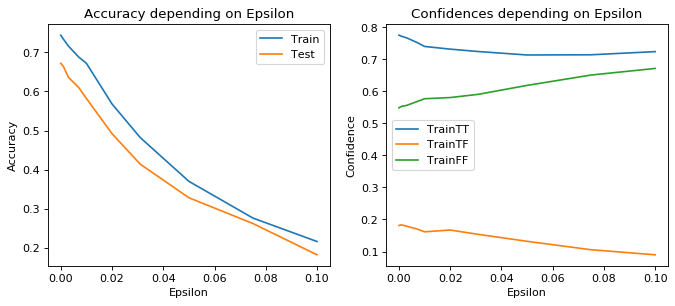

In [0]:
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(121)
plt.plot(epsilons, resAccTr)
plt.plot(epsilons, resAccTe)
plt.title('Accuracy depending on Epsilon')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.subplot(122)
plt.plot(epsilons, resConfTTTr)
plt.plot(epsilons, resConfTFTr)
plt.plot(epsilons, resConfFFTr)
plt.title('Confidences depending on Epsilon')
plt.ylabel('Confidence')
plt.xlabel('Epsilon')
plt.legend(['TrainTT', 'TrainTF', 'TrainFF'], loc='center left')
plt.show()

Certains résultats en revanche, sont plus intéressants, on présente les 4 exemples suivants pour lesquels la perturbation ne touche pas l'animal ou l'objet sujet de l'image mais pour lesquels la prédiction devient erronnée.

Il est donc possible d'effectuer une attaque adversariale en modifiant une partie d'une image supposée peu utile pour la reconnaissance.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


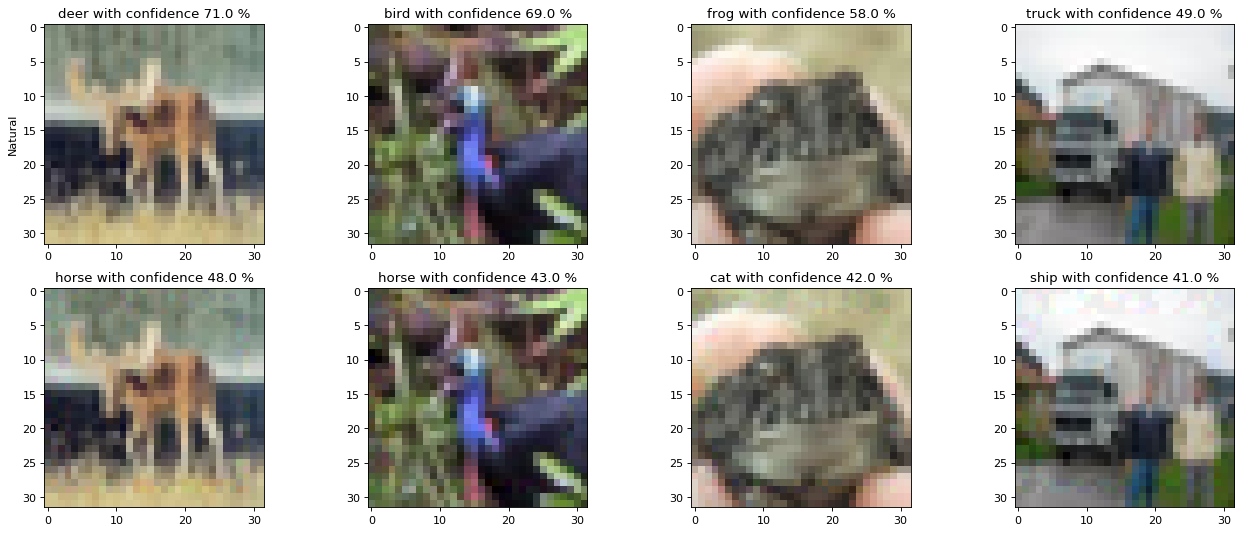

In [0]:
examples = [28,24,25,16]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = get_attacks([x_train[abcd] for abcd in examples], [perturbations2_train[bcde] for bcde in examples], 0.031)

for i in range(len(examples)):
  predicti1 = model.predict(x_train[examples[i]].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(x_train[examples[i]])
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  if(i ==0):
    plt.ylabel('Natural')
  
  predicti2 = model.predict(imgsadv[i].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+4+1)
  plt.imshow(imgsadv[i].reshape(32,32,3))
  plt.title("{} with confidence {} %".format(classes[predicti2.argmax()], predicti2.max()//0.01))
  if(i ==4):
    plt.ylabel('Adversarial')
plt.show()


##**3.Attaque aléatoire**

Pour finir, nous nous sommes posé une question, en s'entrainant sur des photos, les réseaux de neurones ne se retrouvent t'ils pas à "overfitter la réalité", en effet une image réel suit certaines normes naturellement, certaines succesions de pixels ne sont pas supposés exister.

Pour pouvoir tester cela, on applique une perturbation sur l´image, dont le sens pour chaque pixel est aléatoire.

In [0]:
epsilons = [0, 0.001, 0.003, 0.007, 0.01, 0.02, 0.031, 0.05, 0.075, 0.1]
resAccTr = []
resConfTTTr = []
resConfTFTr = []
resConfFFTr = []
resAccTe = []
resConfTTTe = []
resConfTFTe = []
resConfFFTe = []
for i in epsilons :
  print(i)
  a, b, c, d = get_evaluation(x_usedtr1, y_usedtr1, get_attacks(x_usedtr1, perturbations3_train, i))
  e, f, g, h = get_evaluation(x_usedte1, y_usedte1, get_attacks(x_usedte1, perturbations3_test, i))
  resAccTr.append(a)
  resConfTTTr.append(b)
  resConfTFTr.append(c)
  resConfFFTr.append(d)
  resAccTe.append(e)
  resConfTTTe.append(f)
  resConfTFTe.append(g)
  resConfFFTe.append(h)

0
True
372
0.5487406322499737 0.18108267415163937 0.7756679922502528
True
336
0.5531501148532076 0.16638999456380388 0.7649651910400107
0.001
True
374
0.552622974746757 0.17888308938459627 0.7732749517190265
True
336
0.5531254904117526 0.16647059466448832 0.7648408350845178
0.003
True
375
0.5548838198184967 0.17779510539630428 0.7721719519297282
True
337
0.5541275534893106 0.16552894505426827 0.763277995834011
0.007
True
375
0.5544048690795899 0.17704779654787853 0.772614294052124
True
337
0.5533034680811174 0.1653465736345631 0.7627416325605941
0.01
True
374
0.5529502318018958 0.17828468478050097 0.7737372164579637
True
335
0.5515109234687053 0.16777473099288975 0.7645690096848047
0.02
True
367
0.5452878220861119 0.18524862104095519 0.7811148018862961
True
333
0.5549252652479503 0.17047426152593054 0.7637474956634166
0.031
True
365
0.5503058506382836 0.17566819879640308 0.7819424920702633
True
328
0.5542886113358099 0.16943126283580948 0.7669174192791305
0.05
True
352
0.55951861201508

Les résultats semblent au final peu concluant, le ré seau se montre robuste face à ce genre d'attaque complètement aléatoires.

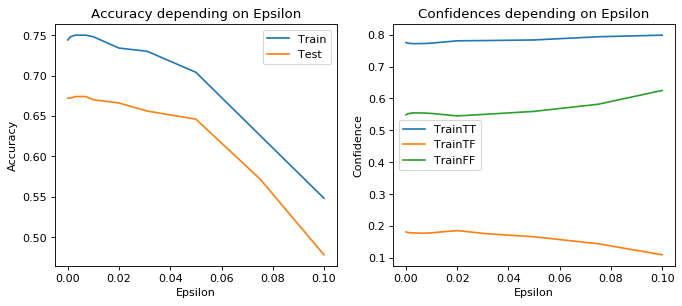

In [0]:
plt.figure(figsize=(10,4), dpi=80)
plt.subplot(121)
plt.plot(epsilons, resAccTr)
plt.plot(epsilons, resAccTe)
plt.title('Accuracy depending on Epsilon')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.subplot(122)
plt.plot(epsilons, resConfTTTr)
plt.plot(epsilons, resConfTFTr)
plt.plot(epsilons, resConfFFTr)
plt.title('Confidences depending on Epsilon')
plt.ylabel('Confidence')
plt.xlabel('Epsilon')
plt.legend(['TrainTT', 'TrainTF', 'TrainFF'], loc='center left')
plt.show()

(1, 32, 32, 3)


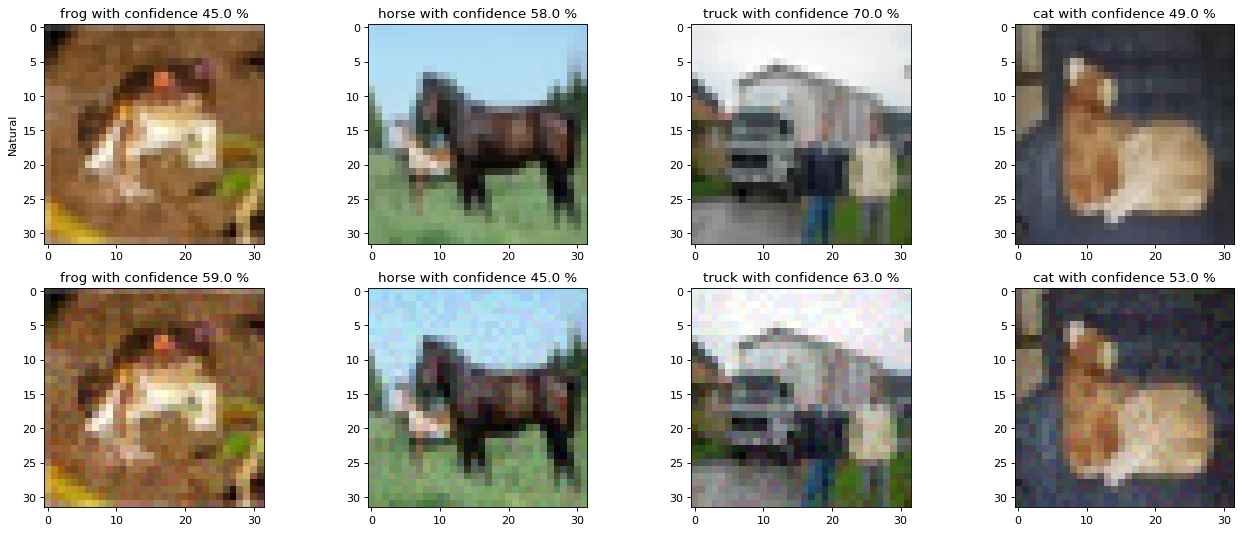

In [0]:
examples = [0,12,16,17]
plt.figure(figsize=(20,8), dpi=80)
imgsadv = get_attacks([x_train[abcd] for abcd in examples], [perturbations3_train[bcde] for bcde in examples], 0.031)
print (imgsadv[0].shape)

for i in range(len(examples)):
  predicti1 = model.predict(x_train[examples[i]].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+1)
  plt.imshow(x_train[examples[i]])
  plt.title("{} with confidence {} %".format(classes[predicti1.argmax()], predicti1.max()//0.01))
  if(i ==0):
    plt.ylabel('Natural')
  
  predicti2 = model.predict(imgsadv[i].reshape(1,32,32,3))
  plt.subplot(2,len(examples), i+4+1)
  plt.imshow(imgsadv[i].reshape(32,32,3))
  plt.title("{} with confidence {} %".format(classes[predicti2.argmax()], predicti2.max()//0.01))
  if(i ==4):
    plt.ylabel('Adversarial')
plt.show()
